In [1]:
# Installation of the requirements
#!python -m pip install -r requirements.txt

In [1]:
'''
(C) Renata Wong 2023

Qiskit code for testing fidelity of derandomised classical shadow on the ground state energy of molecules.

Procedure:
1. Derandomize the molecule-in-question's Hamiltonian.
2. Choose a variational ansatz with initial parameters selected at random.
3. Apply the derandomized Hamiltonian as basis change operators to the ansatz.
4. Measure the ansatz in the Pauli Z basis and store the results as a shadow.
5. Obtain the expectation value of the molecular Hamiltonian from the shadow.
6. Optimize for minimum Hamiltonian expectation value. 
7. Feed the calculated angles/parameters back to the ansatz.
8. Repeat steps 3-7 till the optimization is completed. 
9. Output the minimized expectation value of the molecular Hamiltonian and the mean-square-root-error. 

Note: Below we perform calculations on the molecular Hamiltonian of H_2.
To perform calculations on other molecules, you will need to specify their geometry, charge and spin 
to replace the values in the driver. 

Note: predicting_quantum_properties module comes from https://github.com/hsinyuan-huang/predicting-quantum-properties
'''

import numpy as np
from collections import Counter
import time
from functools import partial

from qiskit.circuit.library import EfficientSU2
from qiskit_aer import QasmSimulator
from qiskit import QuantumCircuit, execute
from qiskit.algorithms.optimizers import SLSQP, COBYLA
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import BravyiKitaevMapper, QubitConverter
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.opflow import I, StateFn, CircuitStateFn

from predicting_quantum_properties.data_acquisition_shadow import derandomized_classical_shadow
from predicting_quantum_properties.prediction_shadow import estimate_exp

from modified_derandomization import modified_derandomized_classical_shadow




# SPECIFY THE NUMBER OF EXPERIMENTS YOU WANT TO RUN
num_experiments = 1

# SPECIFY THE EXPECTED GROUND STATE ENERGY FOR THE MOLECULE OF INTEREST
EXPECTED_EIGENVALUE = -1.86

# SPECIFY THE GEOMETRY OF THE MOLECULE IN QUESTION
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


problem = driver.run()
hamiltonian = problem.hamiltonian

# The electronic Hamiltonian of the system
second_q_op = hamiltonian.second_q_op()

# Solving the electronic structure problem = determine the ground state energy of the molecule
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory
from qiskit_nature.second_q.mappers import BravyiKitaevMapper

# The Bravyi-Kitaev repserentation of the Fermionic Hamiltonian
mapper = BravyiKitaevMapper()
bkenc_hamiltonian = mapper.map(second_q_op)

print(bkenc_hamiltonian)

/home/renata/.local/lib/python3.8/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


-0.8105479805373264 * IIII
+ 0.17218393261915543 * IIIZ
- 0.22575349222402474 * IIZZ
+ 0.1209126326177664 * IIZI
+ 0.1721839326191556 * IZII
+ 0.1689275387008791 * IZIZ
+ 0.04523279994605785 * ZXIX
- 0.04523279994605785 * IXZX
- 0.04523279994605785 * ZXZX
+ 0.04523279994605785 * IXIX
- 0.22575349222402485 * ZZZI
+ 0.1661454325638242 * ZZZZ
+ 0.16614543256382422 * IZZZ
+ 0.1746434306830045 * ZZIZ
+ 0.1209126326177664 * ZIZI


/home/renata/.local/lib/python3.8/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


In [2]:
'''
Format Hamiltonian terms and coefficients as required by the package predicting-quantum-properties
'''

hamiltonian_terms = []
weights = []

for observable in bkenc_hamiltonian:
    
    observable_str = str(observable)
    observable_str_clean = observable_str.strip()  # removes white spaces
    pauli_str_list = observable_str_clean.split('*')
    tuple_list = []
    
    for op_index, pauli_op in enumerate(pauli_str_list[1]):
        if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
            tuple_list.append((pauli_op, op_index-1))
    if len(tuple_list) > 0:
        hamiltonian_terms.append(tuple_list)
        weights.append(float(pauli_str_list[0].strip()))

system_size = len(hamiltonian_terms[0])

print(hamiltonian_terms)
print(weights)



'''
Reformatting the Hamiltonian for use in estimate_exp(): removing all entries with Pauli I. 
'''

hamiltonian_terms_XYZE = []

for term in hamiltonian_terms:
    term_XYZE = []
    for pauli in term:
        if pauli[0] != 'I':
            term_XYZE.append(pauli)
    hamiltonian_terms_XYZE.append(term_XYZE)   
    

abs_weights = [abs(weight) for weight in weights]

hamiltonian_terms_XYZ = []
for idx, term in enumerate(hamiltonian_terms_XYZE):
    if term:
        hamiltonian_terms_XYZ.append(term)
    else:
        abs_weights.pop(idx)
        
print('Hamiltonian terms without Pauli-I:\n', hamiltonian_terms_XYZ)
print('Absolute weights:\n', abs_weights)

[[('I', 0), ('I', 1), ('I', 2), ('I', 3)], [('I', 0), ('I', 1), ('I', 2), ('Z', 3)], [('I', 0), ('I', 1), ('Z', 2), ('Z', 3)], [('I', 0), ('I', 1), ('Z', 2), ('I', 3)], [('I', 0), ('Z', 1), ('I', 2), ('I', 3)], [('I', 0), ('Z', 1), ('I', 2), ('Z', 3)], [('Z', 0), ('X', 1), ('I', 2), ('X', 3)], [('I', 0), ('X', 1), ('Z', 2), ('X', 3)], [('Z', 0), ('X', 1), ('Z', 2), ('X', 3)], [('I', 0), ('X', 1), ('I', 2), ('X', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('I', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('I', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('Z', 0), ('Z', 1), ('I', 2), ('Z', 3)], [('Z', 0), ('I', 1), ('Z', 2), ('I', 3)]]
[-0.8105479805373264, 0.17218393261915543, -0.22575349222402474, 0.1209126326177664, 0.1721839326191556, 0.1689275387008791, 0.04523279994605785, -0.04523279994605785, -0.04523279994605785, 0.04523279994605785, -0.22575349222402485, 0.1661454325638242, 0.16614543256382422, 0.1746434306830045, 0.1209126326177664]
Hamiltonian terms without Pauli-I:
 [[('Z', 3)], [('Z',

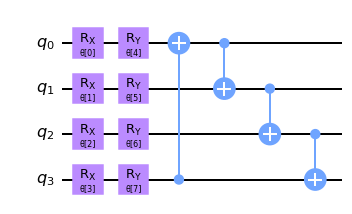

In [3]:
'''
Choose a variational ansatz.
Note that for molecules other than H_2 you may need to specify a different number of reps.
'''

reps = 1   
ansatz = EfficientSU2(system_size, su2_gates=['rx', 'ry'], entanglement='circular', reps=reps, skip_final_rotation_layer=True)  
    
ansatz.decompose().draw('mpl')

In [5]:
'''
Define the cost function
'''


backend = QasmSimulator(method='statevector', shots=1)


# Create circuit with just the randomised basis change operators
def rand_meas_circuit(pauli_op):
    rand_meas = QuantumCircuit(ansatz.num_qubits)
    for idx, op in enumerate(pauli_op):
        if op == 'X':
            rand_meas.x(idx)
        elif op == 'Y':
            rand_meas.y(idx)
        elif op == 'Z':
            rand_meas.z(idx)
    return rand_meas


def objective_function(operators, params):
    
    # Assign parameters to the ansatz and simulate it
    # Generate circuits to measure random Paulis, one circuit for each Pauli
    
    shadow = []
    for pauli_op in operators:
        qc = ansatz.bind_parameters(params)
        qc.compose(rand_meas_circuit(pauli_op))
        qc.measure_all()
        result = execute(qc, backend, shots=1).result()
        counts = result.get_counts()
        
        
        # We perform one single shot => index(1)
        # store the shadow in the form [[(Z,1),(Z,-1)...], [(Y,-1),(X,-1),...]] where inner list = snapshot
        # Because measurement output in Qiskit gives us states and not eigenvalues, we need to convert 0->1 and 1->-1
        
        output_str = list(list(counts.keys())[list(counts.values()).index(1)])
        output = [int(i) for i in output_str]
        eigenvals = [x+1 if x == 0 else x-2 for x in output]
        snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
        shadow.append(snapshot)
    
    
    # Now, we want to get the expectation values for the Hamiltonian from the shadow using the function
    # estimate_exp(full_measurement, one_observable)
    # where full_measurement = shadow and one_observable is any term in the Hamiltonian with I observable excluded.
    # cost = the total expectation value of the Hamiltonian
    # NOTE: We need to check for match_count value since it may happen that it is equal to 0. 
    # Such experiments need to be excluded. 
    # The problem is due to the derandomization algorithm not always producing Paulis that 'hit' the Hamiltonian terms.
    
    cost = 0.0
    for term, weight in zip(hamiltonian_terms_XYZE, weights):
        sum_product, match_count = estimate_exp(shadow, term)
        if match_count != 0:
            exp_val = sum_product / match_count
            cost = cost + (weight * exp_val)
            
        
    cost_history.append(cost)
    
    return cost


In [5]:
'''
Classical optimisation step
'''

# Counter for the execution time
start_time = time.time()


# Classical optimizer
optimizer = COBYLA(maxiter=500)   

# Collect the expectation value from each experiment
expectation_values = []

# number of operators to generate
num_operators = 250

# generate the derandomized Hamiltonian operators (num_operators many)
derandomized_hamiltonian = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_operators, system_size, weight=abs_weights)

cost_function = partial(objective_function, derandomized_hamiltonian)

tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
counts = Counter(tuples)

print('NUMBER OF OPERATORS', num_operators)
print('OPERATORS', counts)


for _ in range(num_experiments):
    cost_history = []
    params = np.random.rand(ansatz.num_parameters)
    result = optimizer.minimize(fun=cost_function, x0=params)
    expectation_values.append(min(cost_history))
    print("GROUND STATE ENERGY FOUND = ", min(cost_history))

    
rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)

print('AVERAGE ERROR', rmse_derandomised_cs)

elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

NUMBER OF OPERATORS 250
OPERATORS Counter({('X', 'X', 'X', 'X'): 196, ('Z', 'Z', 'Z', 'Z'): 41, ('Z', 'X', 'X', 'X'): 6, ('Z', 'X', 'Z', 'X'): 5, ('Z', 'Z', 'X', 'Z'): 2})
GROUND STATE ENERGY FOUND =  -1.298983483909355
AVERAGE ERROR 0.5610165160906451
Execution time =  00:03:12


In [8]:
'''
Above we have assumed a particular ground state energy for the molecule of interest.
Below we corroborate this assumption using a classical minimum eigensolver on our Hamiltonian.
'''

converter = QubitConverter(BravyiKitaevMapper())
numpy_solver = NumPyMinimumEigensolver()   

calc = GroundStateEigensolver(converter, numpy_solver)
res = calc.solve(problem)
print('Electronic ground state energy:\n', res) 

Electronic ground state energy:
 === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.388948701555]
    - computed part:      [0.0  0.0  1.388948701555]
  > Dipole moment (a.u.): [0.0  0.0  -0.000000001555]  Total: 0.000000001555
                 (debye): [0.0  0.0  -0.000000003953]  Total: 0.000000003953
 


/tmp/ipykernel_171/3874215217.py:6: DeprecationWarning: The QubitConverter class is deprecated as of version 0.6.0 and will be removed no sooner than 3 months after the release . Instead you should directly use the QubitMapper instance which you used to pass into the QubitConverter as the first argument. Refer to the documentation of the qiskit_nature.second_q.mappers module for more information.
  converter = QubitConverter(BravyiKitaevMapper())


In [8]:
'''
It is difficult to specify a number of minimum evaluations per observable that would generate a derandomization scheme covering 
the original Hamiltonian observables well. For that reason, we generate some statistics to check for possible patterns
in generating good derandomizations. 
This is only a helper function, not to be treated as part of the algorithm.
NOTE: THESE OEPRATORS ARE OBTAINED IF THE ENTIRE HAMILTONIAN (INCLUDING PAULI-I) IS PASSED TO DERANDOMIZATION.
IF PAULI-I ARE OMITTED, OTHER OPERATORS ARE OBTAINED.
'''

print(f'NUM_EVALS - DERAND_OBS')

for num_obs_evals in range(1, 1001):

    derandomized_hamiltonians = derandomized_classical_shadow(hamiltonian_terms, 
                                                                num_obs_evals, system_size, weight=weights)
    tuples = (tuple(pauli) for pauli in derandomized_hamiltonians)
    counts = Counter(tuples)
        
    print('{} - {}'.format(num_obs_evals, counts))

NUM_EVALS - DERAND_OBS
1 - Counter({('X', 'X', 'X', 'X'): 1})
2 - Counter({('X', 'X', 'X', 'X'): 1})
3 - Counter({('X', 'X', 'X', 'X'): 1})
4 - Counter({('X', 'X', 'X', 'X'): 1})
5 - Counter({('X', 'X', 'X', 'X'): 1})
6 - Counter({('Z', 'Z', 'X', 'X'): 90})
7 - Counter({('Z', 'Z', 'X', 'X'): 104, ('Z', 'Z', 'Z', 'Z'): 1})
8 - Counter({('Z', 'Z', 'X', 'X'): 119, ('Z', 'Z', 'Z', 'Z'): 1})
9 - Counter({('Z', 'Z', 'X', 'X'): 134, ('Z', 'Z', 'Z', 'Z'): 1})
10 - Counter({('Z', 'Z', 'X', 'X'): 149, ('Z', 'Z', 'Z', 'Z'): 1})
11 - Counter({('Z', 'Z', 'X', 'X'): 164, ('Z', 'Z', 'Z', 'Z'): 1})
12 - Counter({('Z', 'Z', 'X', 'X'): 179, ('Z', 'Z', 'Z', 'Z'): 1})
13 - Counter({('Z', 'Z', 'X', 'X'): 193, ('Z', 'Z', 'Z', 'Z'): 2})
14 - Counter({('Z', 'Z', 'X', 'X'): 208, ('Z', 'Z', 'Z', 'Z'): 2})
15 - Counter({('Z', 'Z', 'X', 'X'): 223, ('Z', 'Z', 'Z', 'Z'): 2})
16 - Counter({('Z', 'Z', 'X', 'X'): 238, ('Z', 'Z', 'Z', 'Z'): 2})
17 - Counter({('Z', 'Z', 'X', 'X'): 253, ('Z', 'Z', 'Z', 'Z'): 2})
18 - Cou

182 - Counter({('Z', 'X', 'X', 'X'): 2730})
183 - Counter({('Z', 'X', 'X', 'X'): 2745})
184 - Counter({('Z', 'X', 'X', 'X'): 2760})
185 - Counter({('Z', 'X', 'X', 'X'): 2775})
186 - Counter({('Z', 'X', 'X', 'X'): 2790})
187 - Counter({('Z', 'X', 'X', 'X'): 2805})
188 - Counter({('Z', 'X', 'X', 'X'): 2820})
189 - Counter({('Z', 'X', 'X', 'X'): 2835})
190 - Counter({('Z', 'X', 'X', 'X'): 2850})
191 - Counter({('Z', 'X', 'X', 'X'): 2865})
192 - Counter({('Z', 'X', 'X', 'X'): 2880})
193 - Counter({('Z', 'X', 'X', 'X'): 2895})
194 - Counter({('Z', 'X', 'X', 'X'): 2910})
195 - Counter({('Z', 'X', 'X', 'X'): 2925})
196 - Counter({('Z', 'X', 'X', 'X'): 2940})
197 - Counter({('Z', 'X', 'X', 'X'): 2955})
198 - Counter({('Z', 'X', 'X', 'X'): 2970})
199 - Counter({('Z', 'X', 'X', 'X'): 2985})
200 - Counter({('Z', 'X', 'X', 'X'): 3000})
201 - Counter({('Z', 'X', 'X', 'X'): 3015})
202 - Counter({('Z', 'X', 'X', 'X'): 3030})
203 - Counter({('Z', 'X', 'X', 'X'): 3045})
204 - Counter({('Z', 'X', 'X', '

369 - Counter({('Z', 'X', 'X', 'X'): 5535})
370 - Counter({('Z', 'X', 'X', 'X'): 5550})
371 - Counter({('Z', 'X', 'X', 'X'): 5565})
372 - Counter({('Z', 'X', 'X', 'X'): 5580})
373 - Counter({('Z', 'X', 'X', 'X'): 5595})
374 - Counter({('Z', 'X', 'X', 'X'): 5610})
375 - Counter({('Z', 'X', 'X', 'X'): 5625})
376 - Counter({('Z', 'X', 'X', 'X'): 5640})
377 - Counter({('Z', 'X', 'X', 'X'): 5655})
378 - Counter({('Z', 'X', 'X', 'X'): 5670})
379 - Counter({('Z', 'X', 'X', 'X'): 5685})
380 - Counter({('Z', 'X', 'X', 'X'): 5700})
381 - Counter({('Z', 'X', 'X', 'X'): 5715})
382 - Counter({('Z', 'X', 'X', 'X'): 5730})
383 - Counter({('Z', 'X', 'X', 'X'): 5745})
384 - Counter({('Z', 'X', 'X', 'X'): 5760})
385 - Counter({('Z', 'X', 'X', 'X'): 5775})
386 - Counter({('Z', 'X', 'X', 'X'): 5790})
387 - Counter({('Z', 'X', 'X', 'X'): 5805})
388 - Counter({('Z', 'X', 'X', 'X'): 5820})
389 - Counter({('Z', 'X', 'X', 'X'): 5835})
390 - Counter({('Z', 'X', 'X', 'X'): 5850})
391 - Counter({('Z', 'X', 'X', '

556 - Counter({('Z', 'X', 'X', 'X'): 8340})
557 - Counter({('Z', 'X', 'X', 'X'): 8355})
558 - Counter({('Z', 'X', 'X', 'X'): 8370})
559 - Counter({('Z', 'X', 'X', 'X'): 8385})
560 - Counter({('Z', 'X', 'X', 'X'): 8400})
561 - Counter({('Z', 'X', 'X', 'X'): 8415})
562 - Counter({('Z', 'X', 'X', 'X'): 8430})
563 - Counter({('Z', 'X', 'X', 'X'): 8445})
564 - Counter({('Z', 'X', 'X', 'X'): 8460})
565 - Counter({('Z', 'X', 'X', 'X'): 8475})
566 - Counter({('Z', 'X', 'X', 'X'): 8490})
567 - Counter({('Z', 'X', 'X', 'X'): 8505})
568 - Counter({('Z', 'X', 'X', 'X'): 8520})
569 - Counter({('Z', 'X', 'X', 'X'): 8535})
570 - Counter({('Z', 'X', 'X', 'X'): 8550})
571 - Counter({('Z', 'X', 'X', 'X'): 8565})
572 - Counter({('Z', 'X', 'X', 'X'): 8580})
573 - Counter({('Z', 'X', 'X', 'X'): 8595})
574 - Counter({('Z', 'X', 'X', 'X'): 8610})
575 - Counter({('Z', 'X', 'X', 'X'): 8625})
576 - Counter({('Z', 'X', 'X', 'X'): 8640})
577 - Counter({('Z', 'X', 'X', 'X'): 8655})
578 - Counter({('Z', 'X', 'X', '

741 - Counter({('Z', 'X', 'X', 'X'): 11115})
742 - Counter({('Z', 'X', 'X', 'X'): 11130})
743 - Counter({('Z', 'X', 'X', 'X'): 11145})
744 - Counter({('Z', 'X', 'X', 'X'): 11160})
745 - Counter({('Z', 'X', 'X', 'X'): 11175})
746 - Counter({('Z', 'X', 'X', 'X'): 11190})
747 - Counter({('Z', 'X', 'X', 'X'): 11205})
748 - Counter({('Z', 'X', 'X', 'X'): 11220})
749 - Counter({('Z', 'X', 'X', 'X'): 11235})
750 - Counter({('Z', 'X', 'X', 'X'): 11250})
751 - Counter({('Z', 'X', 'X', 'X'): 11265})
752 - Counter({('Z', 'X', 'X', 'X'): 11280})
753 - Counter({('Z', 'X', 'X', 'X'): 11295})
754 - Counter({('Z', 'X', 'X', 'X'): 11310})
755 - Counter({('Z', 'X', 'X', 'X'): 11325})
756 - Counter({('Z', 'X', 'X', 'X'): 11340})
757 - Counter({('Z', 'X', 'X', 'X'): 11355})
758 - Counter({('Z', 'X', 'X', 'X'): 11370})
759 - Counter({('Z', 'X', 'X', 'X'): 11385})
760 - Counter({('Z', 'X', 'X', 'X'): 11400})
761 - Counter({('Z', 'X', 'X', 'X'): 11415})
762 - Counter({('Z', 'X', 'X', 'X'): 11430})
763 - Coun

924 - Counter({('Z', 'X', 'X', 'X'): 13860})
925 - Counter({('Z', 'X', 'X', 'X'): 13875})
926 - Counter({('Z', 'X', 'X', 'X'): 13890})
927 - Counter({('Z', 'X', 'X', 'X'): 13905})
928 - Counter({('Z', 'X', 'X', 'X'): 13920})
929 - Counter({('Z', 'X', 'X', 'X'): 13935})
930 - Counter({('Z', 'X', 'X', 'X'): 13950})
931 - Counter({('Z', 'X', 'X', 'X'): 13965})
932 - Counter({('Z', 'X', 'X', 'X'): 13980})
933 - Counter({('Z', 'X', 'X', 'X'): 13995})
934 - Counter({('Z', 'X', 'X', 'X'): 14010})
935 - Counter({('Z', 'X', 'X', 'X'): 14025})
936 - Counter({('Z', 'X', 'X', 'X'): 14040})
937 - Counter({('Z', 'X', 'X', 'X'): 14055})
938 - Counter({('Z', 'X', 'X', 'X'): 14070})
939 - Counter({('Z', 'X', 'X', 'X'): 14085})
940 - Counter({('Z', 'X', 'X', 'X'): 14100})
941 - Counter({('Z', 'X', 'X', 'X'): 14115})
942 - Counter({('Z', 'X', 'X', 'X'): 14130})
943 - Counter({('Z', 'X', 'X', 'X'): 14145})
944 - Counter({('Z', 'X', 'X', 'X'): 14160})
945 - Counter({('Z', 'X', 'X', 'X'): 14175})
946 - Coun

In [9]:
'''
It is difficult to specify a number of minimum evaluations per observable that would generate a derandomization scheme covering 
the original Hamiltonian observables well. For that reason, we generate some statistics to check for possible patterns
in generating good derandomizations. 
This is only a helper function, not to be treated as part of the algorithm.
NOTE: THESE OEPRATORS ARE OBTAINED IF THE HAMILTONIAN WITHOUT ANY PAULI-I IS PASSED TO DERANDOMIZATION.
'''

print(f'NUM_EVALS - DERAND_OBS')
for num_obs_evals in range(1, 1001):

    derandomized_hamiltonians = derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                num_obs_evals, system_size, weight=abs_weights)
    tuples = (tuple(pauli) for pauli in derandomized_hamiltonians)
    counts = Counter(tuples)
        
    print('{} - {}'.format(num_obs_evals, counts))

NUM_EVALS - DERAND_OBS
1 - Counter({('X', 'X', 'X', 'X'): 1})
2 - Counter({('X', 'X', 'X', 'X'): 1})
3 - Counter({('X', 'X', 'X', 'X'): 1})
4 - Counter({('X', 'X', 'X', 'X'): 1})
5 - Counter({('Z', 'Z', 'Z', 'Z'): 1})
6 - Counter({('Z', 'Z', 'Z', 'Z'): 1})
7 - Counter({('Z', 'Z', 'Z', 'Z'): 1})
8 - Counter({('Z', 'Z', 'Z', 'Z'): 1})
9 - Counter({('Z', 'Z', 'Z', 'Z'): 2})
10 - Counter({('Z', 'Z', 'Z', 'Z'): 2})
11 - Counter({('Z', 'Z', 'Z', 'Z'): 2})
12 - Counter({('Z', 'Z', 'Z', 'Z'): 2})
13 - Counter({('Z', 'Z', 'Z', 'Z'): 2})
14 - Counter({('Z', 'Z', 'Z', 'Z'): 3})
15 - Counter({('Z', 'Z', 'Z', 'Z'): 3})
16 - Counter({('Z', 'Z', 'Z', 'Z'): 3})
17 - Counter({('Z', 'Z', 'Z', 'Z'): 3})
18 - Counter({('Z', 'Z', 'Z', 'Z'): 4})
19 - Counter({('Z', 'Z', 'Z', 'Z'): 4})
20 - Counter({('Z', 'Z', 'Z', 'Z'): 4})
21 - Counter({('Z', 'Z', 'Z', 'Z'): 4})
22 - Counter({('Z', 'Z', 'Z', 'Z'): 4})
23 - Counter({('Z', 'Z', 'Z', 'Z'): 5, ('Z', 'X', 'Z', 'X'): 1})
24 - Counter({('Z', 'Z', 'Z', 'Z'): 5, ('

119 - Counter({('Z', 'Z', 'Z', 'Z'): 25, ('Z', 'X', 'Z', 'X'): 5, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
120 - Counter({('Z', 'Z', 'Z', 'Z'): 26, ('Z', 'X', 'Z', 'X'): 5, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
121 - Counter({('Z', 'Z', 'Z', 'Z'): 26, ('Z', 'X', 'Z', 'X'): 5, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
122 - Counter({('Z', 'Z', 'Z', 'Z'): 26, ('Z', 'X', 'Z', 'X'): 5, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
123 - Counter({('Z', 'Z', 'Z', 'Z'): 26, ('Z', 'X', 'Z', 'X'): 5, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
124 - Counter({('Z', 'Z', 'Z', 'Z'): 26, ('Z', 'X', 'Z', 'X'): 5, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
125 - Counter({('Z', 'Z', 'Z', 'Z'): 27, ('Z', 'X', 'Z', 'X'): 5, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
126 - Counter({('Z', 'Z', 'Z', 'Z'): 27, ('Z', 'X', 'Z', 'X'): 5, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
127 - Counter({('Z', 'Z', 'Z', 'Z'): 27, ('Z', 'X', 'Z', 'X'): 5

202 - Counter({('Z', 'Z', 'Z', 'Z'): 44, ('Z', 'X', 'Z', 'X'): 9, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
203 - Counter({('Z', 'Z', 'Z', 'Z'): 44, ('Z', 'X', 'Z', 'X'): 9, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
204 - Counter({('Z', 'Z', 'Z', 'Z'): 45, ('Z', 'X', 'Z', 'X'): 9, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
205 - Counter({('Z', 'Z', 'Z', 'Z'): 45, ('Z', 'X', 'Z', 'X'): 9, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
206 - Counter({('Z', 'Z', 'Z', 'Z'): 45, ('Z', 'X', 'Z', 'X'): 9, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
207 - Counter({('Z', 'Z', 'Z', 'Z'): 45, ('Z', 'X', 'Z', 'X'): 9, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
208 - Counter({('Z', 'Z', 'Z', 'Z'): 45, ('Z', 'X', 'Z', 'X'): 9, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
209 - Counter({('Z', 'Z', 'Z', 'Z'): 46, ('Z', 'X', 'Z', 'X'): 9, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
210 - Counter({('Z', 'Z', 'Z', 'Z'): 46, ('Z', 'X', 'Z', 'X'): 9

274 - Counter({('Z', 'Z', 'Z', 'Z'): 60, ('Z', 'X', 'Z', 'X'): 12, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
275 - Counter({('Z', 'Z', 'Z', 'Z'): 61, ('Z', 'X', 'Z', 'X'): 12, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
276 - Counter({('Z', 'Z', 'Z', 'Z'): 61, ('Z', 'X', 'Z', 'X'): 12, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
277 - Counter({('Z', 'Z', 'Z', 'Z'): 61, ('Z', 'X', 'Z', 'X'): 12, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
278 - Counter({('Z', 'Z', 'Z', 'Z'): 61, ('Z', 'X', 'Z', 'X'): 12, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
279 - Counter({('Z', 'Z', 'Z', 'Z'): 61, ('Z', 'X', 'Z', 'X'): 12, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
280 - Counter({('Z', 'Z', 'Z', 'Z'): 62, ('Z', 'X', 'Z', 'X'): 12, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
281 - Counter({('Z', 'Z', 'Z', 'Z'): 62, ('Z', 'X', 'Z', 'X'): 12, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
282 - Counter({('Z', 'Z', 'Z', 'Z'): 62, ('Z', 'X', 'Z',

345 - Counter({('Z', 'Z', 'Z', 'Z'): 76, ('Z', 'X', 'Z', 'X'): 15, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
346 - Counter({('Z', 'Z', 'Z', 'Z'): 77, ('Z', 'X', 'Z', 'X'): 15, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
347 - Counter({('Z', 'Z', 'Z', 'Z'): 77, ('Z', 'X', 'Z', 'X'): 15, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
348 - Counter({('Z', 'Z', 'Z', 'Z'): 77, ('Z', 'X', 'Z', 'X'): 15, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
349 - Counter({('Z', 'Z', 'Z', 'Z'): 77, ('Z', 'X', 'Z', 'X'): 15, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
350 - Counter({('Z', 'Z', 'Z', 'Z'): 78, ('Z', 'X', 'Z', 'X'): 15, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
351 - Counter({('Z', 'Z', 'Z', 'Z'): 78, ('Z', 'X', 'Z', 'X'): 15, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
352 - Counter({('Z', 'Z', 'Z', 'Z'): 78, ('Z', 'X', 'Z', 'X'): 15, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
353 - Counter({('Z', 'Z', 'Z', 'Z'): 78, ('Z', 'X', 'Z',

425 - Counter({('Z', 'Z', 'Z', 'Z'): 94, ('Z', 'X', 'Z', 'X'): 19, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
426 - Counter({('Z', 'Z', 'Z', 'Z'): 95, ('Z', 'X', 'Z', 'X'): 19, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
427 - Counter({('Z', 'Z', 'Z', 'Z'): 95, ('Z', 'X', 'Z', 'X'): 19, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
428 - Counter({('Z', 'Z', 'Z', 'Z'): 95, ('Z', 'X', 'Z', 'X'): 19, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
429 - Counter({('Z', 'Z', 'Z', 'Z'): 95, ('Z', 'X', 'Z', 'X'): 19, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
430 - Counter({('Z', 'Z', 'Z', 'Z'): 96, ('Z', 'X', 'Z', 'X'): 19, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
431 - Counter({('Z', 'Z', 'Z', 'Z'): 96, ('Z', 'X', 'Z', 'X'): 19, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
432 - Counter({('Z', 'Z', 'Z', 'Z'): 96, ('Z', 'X', 'Z', 'X'): 19, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
433 - Counter({('Z', 'Z', 'Z', 'Z'): 96, ('Z', 'X', 'Z',

500 - Counter({('Z', 'Z', 'Z', 'Z'): 111, ('Z', 'X', 'Z', 'X'): 22, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
501 - Counter({('Z', 'Z', 'Z', 'Z'): 112, ('Z', 'X', 'Z', 'X'): 22, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
502 - Counter({('Z', 'Z', 'Z', 'Z'): 112, ('Z', 'X', 'Z', 'X'): 22, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
503 - Counter({('Z', 'Z', 'Z', 'Z'): 112, ('Z', 'X', 'Z', 'X'): 22, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
504 - Counter({('Z', 'Z', 'Z', 'Z'): 112, ('Z', 'X', 'Z', 'X'): 22, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
505 - Counter({('Z', 'Z', 'Z', 'Z'): 113, ('Z', 'X', 'Z', 'X'): 22, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
506 - Counter({('Z', 'Z', 'Z', 'Z'): 113, ('Z', 'X', 'Z', 'X'): 22, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
507 - Counter({('Z', 'Z', 'Z', 'Z'): 113, ('Z', 'X', 'Z', 'X'): 22, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
508 - Counter({('Z', 'Z', 'Z', 'Z'): 113, ('Z', 

572 - Counter({('Z', 'Z', 'Z', 'Z'): 128, ('Z', 'X', 'Z', 'X'): 25, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
573 - Counter({('Z', 'Z', 'Z', 'Z'): 128, ('Z', 'X', 'Z', 'X'): 25, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
574 - Counter({('Z', 'Z', 'Z', 'Z'): 128, ('Z', 'X', 'Z', 'X'): 25, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
575 - Counter({('Z', 'Z', 'Z', 'Z'): 128, ('Z', 'X', 'Z', 'X'): 26, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
576 - Counter({('Z', 'Z', 'Z', 'Z'): 129, ('Z', 'X', 'Z', 'X'): 26, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
577 - Counter({('Z', 'Z', 'Z', 'Z'): 129, ('Z', 'X', 'Z', 'X'): 26, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
578 - Counter({('Z', 'Z', 'Z', 'Z'): 129, ('Z', 'X', 'Z', 'X'): 26, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
579 - Counter({('Z', 'Z', 'Z', 'Z'): 129, ('Z', 'X', 'Z', 'X'): 26, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
580 - Counter({('Z', 'Z', 'Z', 'Z'): 129, ('Z', 

643 - Counter({('Z', 'Z', 'Z', 'Z'): 144, ('Z', 'X', 'Z', 'X'): 29, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
644 - Counter({('Z', 'Z', 'Z', 'Z'): 144, ('Z', 'X', 'Z', 'X'): 29, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
645 - Counter({('Z', 'Z', 'Z', 'Z'): 144, ('Z', 'X', 'Z', 'X'): 29, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
646 - Counter({('Z', 'Z', 'Z', 'Z'): 144, ('Z', 'X', 'Z', 'X'): 29, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
647 - Counter({('Z', 'Z', 'Z', 'Z'): 145, ('Z', 'X', 'Z', 'X'): 29, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
648 - Counter({('Z', 'Z', 'Z', 'Z'): 145, ('Z', 'X', 'Z', 'X'): 29, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
649 - Counter({('Z', 'Z', 'Z', 'Z'): 145, ('Z', 'X', 'Z', 'X'): 29, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
650 - Counter({('Z', 'Z', 'Z', 'Z'): 145, ('Z', 'X', 'Z', 'X'): 29, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
651 - Counter({('Z', 'Z', 'Z', 'Z'): 145, ('Z', 

714 - Counter({('Z', 'Z', 'Z', 'Z'): 160, ('Z', 'X', 'Z', 'X'): 32, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
715 - Counter({('Z', 'Z', 'Z', 'Z'): 160, ('Z', 'X', 'Z', 'X'): 32, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
716 - Counter({('Z', 'Z', 'Z', 'Z'): 160, ('Z', 'X', 'Z', 'X'): 32, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
717 - Counter({('Z', 'Z', 'Z', 'Z'): 160, ('Z', 'X', 'Z', 'X'): 32, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
718 - Counter({('Z', 'Z', 'Z', 'Z'): 161, ('Z', 'X', 'Z', 'X'): 32, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
719 - Counter({('Z', 'Z', 'Z', 'Z'): 161, ('Z', 'X', 'Z', 'X'): 32, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
720 - Counter({('Z', 'Z', 'Z', 'Z'): 161, ('Z', 'X', 'Z', 'X'): 32, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
721 - Counter({('Z', 'Z', 'Z', 'Z'): 161, ('Z', 'X', 'Z', 'X'): 32, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
722 - Counter({('Z', 'Z', 'Z', 'Z'): 161, ('Z', 

786 - Counter({('Z', 'Z', 'Z', 'Z'): 176, ('Z', 'X', 'Z', 'X'): 35, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
787 - Counter({('Z', 'Z', 'Z', 'Z'): 176, ('Z', 'X', 'Z', 'X'): 35, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
788 - Counter({('Z', 'Z', 'Z', 'Z'): 176, ('Z', 'X', 'Z', 'X'): 35, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
789 - Counter({('Z', 'Z', 'Z', 'Z'): 177, ('Z', 'X', 'Z', 'X'): 35, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
790 - Counter({('Z', 'Z', 'Z', 'Z'): 177, ('Z', 'X', 'Z', 'X'): 35, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
791 - Counter({('Z', 'Z', 'Z', 'Z'): 177, ('Z', 'X', 'Z', 'X'): 35, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
792 - Counter({('Z', 'Z', 'Z', 'Z'): 177, ('Z', 'X', 'Z', 'X'): 35, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
793 - Counter({('Z', 'Z', 'Z', 'Z'): 178, ('Z', 'X', 'Z', 'X'): 35, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
794 - Counter({('Z', 'Z', 'Z', 'Z'): 178, ('Z', 

852 - Counter({('X', 'X', 'X', 'X'): 11701, ('Z', 'Z', 'Z', 'Z'): 187, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
853 - Counter({('X', 'X', 'X', 'X'): 11715, ('Z', 'Z', 'Z', 'Z'): 187, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
854 - Counter({('X', 'X', 'X', 'X'): 11729, ('Z', 'Z', 'Z', 'Z'): 187, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
855 - Counter({('X', 'X', 'X', 'X'): 11743, ('Z', 'Z', 'Z', 'Z'): 187, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
856 - Counter({('X', 'X', 'X', 'X'): 11757, ('Z', 'Z', 'Z', 'Z'): 187, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
857 - Counter({('X', 'X', 'X', 'X'): 11771, ('Z', 'Z', 'Z', 'Z'): 187, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1})
858 - Counter({('X', 'X', 'X', 'X'): 11785, ('Z', 'Z', 'Z', 'Z'): 187, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z',

917 - Counter({('X', 'X', 'X', 'X'): 12614, ('Z', 'Z', 'Z', 'Z'): 185, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1})
918 - Counter({('X', 'X', 'X', 'X'): 12628, ('Z', 'Z', 'Z', 'Z'): 185, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1})
919 - Counter({('X', 'X', 'X', 'X'): 12642, ('Z', 'Z', 'Z', 'Z'): 185, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1})
920 - Counter({('X', 'X', 'X', 'X'): 12656, ('Z', 'Z', 'Z', 'Z'): 185, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1})
921 - Counter({('X', 'X', 'X', 'X'): 12670, ('Z', 'Z', 'Z', 'Z'): 185, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1})
922 - Counter({('X', 'X', 'X', 'X'): 12684, ('Z', 'Z', 'Z', 'Z'): 185, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1})
923 - Counter({('X', 'X', 'X', 'X'): 12698, ('Z', 'Z', 'Z', 'Z'): 185, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1})
924 - Counter({('X', 'X', 'X', 'X'): 12712, ('Z', 'Z', 'Z', 'Z'): 185, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1})
925 - Counter({(

984 - Counter({('X', 'X', 'X', 'X'): 13552, ('Z', 'Z', 'Z', 'Z'): 185, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1})
985 - Counter({('X', 'X', 'X', 'X'): 13566, ('Z', 'Z', 'Z', 'Z'): 185, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1})
986 - Counter({('X', 'X', 'X', 'X'): 13580, ('Z', 'Z', 'Z', 'Z'): 185, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1})
987 - Counter({('X', 'X', 'X', 'X'): 13594, ('Z', 'Z', 'Z', 'Z'): 185, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1})
988 - Counter({('X', 'X', 'X', 'X'): 13608, ('Z', 'Z', 'Z', 'Z'): 185, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1})
989 - Counter({('X', 'X', 'X', 'X'): 13622, ('Z', 'Z', 'Z', 'Z'): 185, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1})
990 - Counter({('X', 'X', 'X', 'X'): 13636, ('Z', 'Z', 'Z', 'Z'): 185, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1})
991 - Counter({('X', 'X', 'X', 'X'): 13650, ('Z', 'Z', 'Z', 'Z'): 185, ('Z', 'X', 'Z', 'X'): 38, ('Z', 'X', 'Z', 'Z'): 1})
992 - Counter({(

In [ ]:
'''
It is difficult to specify a number of minimum evaluations per observable that would generate a derandomization scheme covering 
the original Hamiltonian observables well. For that reason, we generate some statistics to check for possible patterns
in generating good derandomizations. 
This is only a helper function, not to be treated as part of the algorithm.
NOTE: THESE OEPRATORS ARE OBTAINED IF THE HAMILTONIAN WITHOUT ANY PAULI-I IS PASSED TO DERANDOMIZATION.
generation of derandomized operators weighted by math.floor(weight[i] * num_operators / len(all_observables))
'''

print(f'NUM_OPERATORS - DERAND_OBS')
for num_operators in range(1, 1001):

    derandomized_hamiltonians = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                num_operators, system_size, weight=abs_weights)
    tuples = (tuple(pauli) for pauli in derandomized_hamiltonians)
    counts = Counter(tuples)
        
    print('{} - {}'.format(num_operators, counts))

In [ ]:
'''
It is difficult to specify a number of minimum evaluations per observable that would generate a derandomization scheme covering 
the original Hamiltonian observables well. For that reason, we generate some statistics to check for possible patterns
in generating good derandomizations. 
This is only a helper function, not to be treated as part of the algorithm.
NOTE: THESE OEPRATORS ARE OBTAINED IF THE HAMILTONIAN WITHOUT ANY PAULI-I IS PASSED TO DERANDOMIZATION.
generation of derandomized operators weighted by math.floor(weight[i])
'''

print(f'NUM_OPERATORS - DERAND_OBS')
for num_operators in range(1, 1001):

    derandomized_hamiltonians = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                num_operators, system_size, weight=abs_weights)
    tuples = (tuple(pauli) for pauli in derandomized_hamiltonians)
    counts = Counter(tuples)
        
    print('{} - {}'.format(num_operators, counts))